# Session 03 - Temporal Difference Learning - Assignment

## 1. Cliff walking

Implement Q-learning and SARSA to solve the cliff walking environment. The cliff walking environment is part of the gymgrid package. 
To install gymgryd: **pip3 install gymgrid**. More information can be found here: https://pypi.org/project/gymgrid/.
The goal for the agent is to find its way from start to finish without falling from the cliff. This is a standard episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked Cliff. Stepping into this region incurs a reward of optimal path -100 and sends the agent instantly back to the start.

- Implement the Q-learning algorithm. Write your own implementation and tune the hyperparameters (learning rate, discount factor, epsilon). Use epsilon decay if necessary. 
- Record the learning history. This means that for each episode you register the total episodic reward. After learning, plot the training history (x-axis = episode number; y-axis: total episodic reward). Especially in the beginning, the episodic rewards can be erratic because the agent is still exploring and has little knowledge of the environment. Therefore it can be a good idea to plot the moving average of the episodic rewards. For example, the average episodic reward achieved over 10 episodes.
- Check if you can make the agent learn faster by using an adaptive learning rate. You start with a high learning rate and you decrease gradually as the agent learns.
- Can you change the reward function in order to make the agent learn faster. For example by changing the reward values or by adding new rewards that make the reward function less sparse.

- Modify you Q-learing implementation to a SARSA implementation.

- Compare Q-learing with SARSA in terms of speed of learning, but especially in terms of the learned policy. 


**Note to myself**: I have to use the conda gym environment for this notebook. I have to go to the conda powershell terminal and type: conda activate gym. Then I can use pip install gymgrid.
*Use the conda gym environment for this notebook.*
- go to conda powershell terminal
- conda activate gym
- pip install gymgrid

In [1]:
# Cliff walking

import gymgrid #pip install gymgrid
import numpy as np
import random
import gym
import matplotlib.pyplot as plt

In [2]:
# Define the agent
class Qagent:
    def __init__(self, nr_states, nr_actions, alpha, gamma, exploration_rate, decay, init_value):
        self.alpha = alpha
        self.gamma = gamma
        self.exploration_rate = exploration_rate
        self.decay = decay
        self.nr_states = nr_states
        self.nr_actions = nr_actions
        self.current_state = 0
        self.previous_state = 0
        self.possibleActions = [0, 1, 2, 3]
        if init_value != 0:
            self.q_table = np.full((nr_states, nr_actions), init_value)
        else:
            self.q_table = np.zeros((nr_states, nr_actions))
        print(self.q_table)
    def compute_action(self, state): #state is integer in nr_states()
        self.state = state
        self.r = random.random()
        if self.r <= self.exploration_rate:
            self.action = random.sample(self.possibleActions, 1)[0] # random.sample returns a list() of one item therefore we need to pick the first element [0] of that list
            # print('exploration')
        else:
            self.action = np.argmax(self.q_table[self.state,:])
            # print(self.r, self.exploration_rate, 'exploitation')
        self.exploration_rate = self.exploration_rate*self.decay
        return self.action
    
    def update_qtable(self, new_state, state, reward):
        self.reward = reward
        self.new_state = new_state
        self.state = state
        
        self.r = random.random()
        if self.r <= self.exploration_rate:
            self.next_q_value = self.q_table[self.new_state, random.sample(self.possibleActions, 1)[0]]
        else:
            self.next_q_value = self.q_table[self.new_state, np.argmax(self.q_table[self.new_state, :])]
        
        self.q_table[self.state, self.action] = (1 - self.alpha)*self.q_table[self.state,self.action]+self.alpha*(self.reward+self.gamma*self.next_q_value)
        
        self.alpha = self.alpha * self.decay


In [3]:
# Calculate Moving averages
def moving_average(source, window_size=2):
    moving_averages = []
    i = 0
    while i < len(source) - window_size + 1:
        window = source[i : i + window_size]
        window_average = round(sum(window)/window_size, 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages

In [4]:
# load the environment
env = gym.make('cliff-v0')

# Define a walking function
def cliffwalk(James):
    threshold = 600
    new_state = env.reset()
    done = False
    t = 0
    episode_reward = 0
    while not done:
        t += 1
        current_state=new_state
        env.render()
        action = James.compute_action(state=current_state)
        new_state, reward, done, _ = env.step(action)
        James.update_qtable(new_state,current_state,reward)
        episode_reward = episode_reward + reward
        if t > threshold: done = True 
    timesteps = t
    return episode_reward, timesteps

# Gymgrid properties
env_states = env.observation_space.n # width = 12 x height = 4
env_actions = env.action_space.n # gymgrid has 8 possible actions if you count the diagonal actions as well
print("States = ",env_states)
print("Actions = ", env_actions)

States =  48
Actions =  4


In [5]:
# self.q_table[self.state, self.action] = (1 - self.alpha)*self.q_table[self.state,self.action]+self.alpha*(self.reward+self.gamma*self.next_q_value)
# Qagent properties
alpha = 0.4
gamma = 0.9
decay = 0.999

# Q-learning
QLepsilon = 0 # Greedy + Q-learning

# SARSA
Sepsilon = 0.2

# Episode properties
episodes = 50

# Initialize collections
QLepisode_rewards = []
QLepisode_timesteps = []
SAepisode_rewards = []
SAepisode_timesteps = []

# Start walking with two agents
QL_James = Qagent(env_states, env_actions, alpha=alpha, gamma=gamma, exploration_rate=QLepsilon, decay=decay, init_value=0)
SA_James = Qagent(env_states, env_actions, alpha=alpha, gamma=gamma, exploration_rate=Sepsilon, decay=decay, init_value=0)

print("Cliff opened")
for i in range(episodes):
    # Q-learning
    Qreward, Qtimestep = cliffwalk(QL_James)
    QLepisode_rewards.append(Qreward)
    QLepisode_timesteps.append(Qtimestep)
    print("Q-Learning with reward {0} in {1} timesteps in episode {2}".format(Qreward, Qtimestep, i))
for i in range(episodes):       
    # SARSA
    Sreward, Stimestep = cliffwalk(SA_James)
    SAepisode_rewards.append(Sreward)
    SAepisode_timesteps.append(Stimestep)
    print("SARSA with reward {0} in {1} timesteps in episode {2}".format(Sreward, Stimestep, i))
env.close()

QLepisode_mean_rewards = moving_average(QLepisode_rewards, 10)
SAepisode_mean_rewards = moving_average(SAepisode_rewards, 10)

print("Final Q-table with Q-learning")
print(QL_James.q_table)

print("Final Q-table with SARSA")
print(SA_James.q_table)

print('Cliff closed')

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0

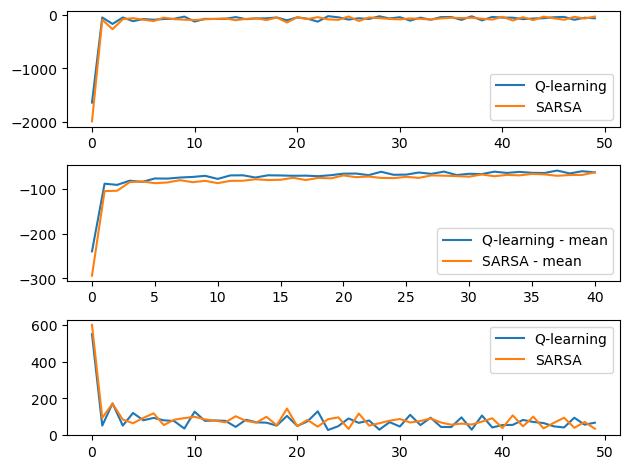

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(QLepisode_rewards, label='Q-learning')
ax1.plot(SAepisode_rewards, label='SARSA')
ax1.legend()

ax2.plot(QLepisode_mean_rewards, label='Q-learning - mean')
ax2.plot(SAepisode_mean_rewards, label='SARSA - mean')
ax2.legend()

ax3.plot(QLepisode_timesteps, label='Q-learning')
ax3.plot(SAepisode_timesteps, label='SARSA')
ax3.legend()
plt.tight_layout()
plt.show()

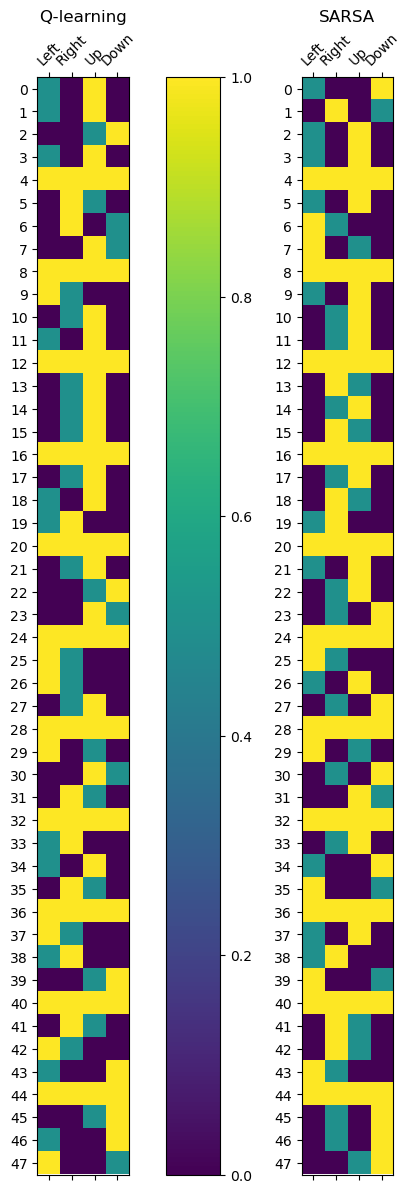

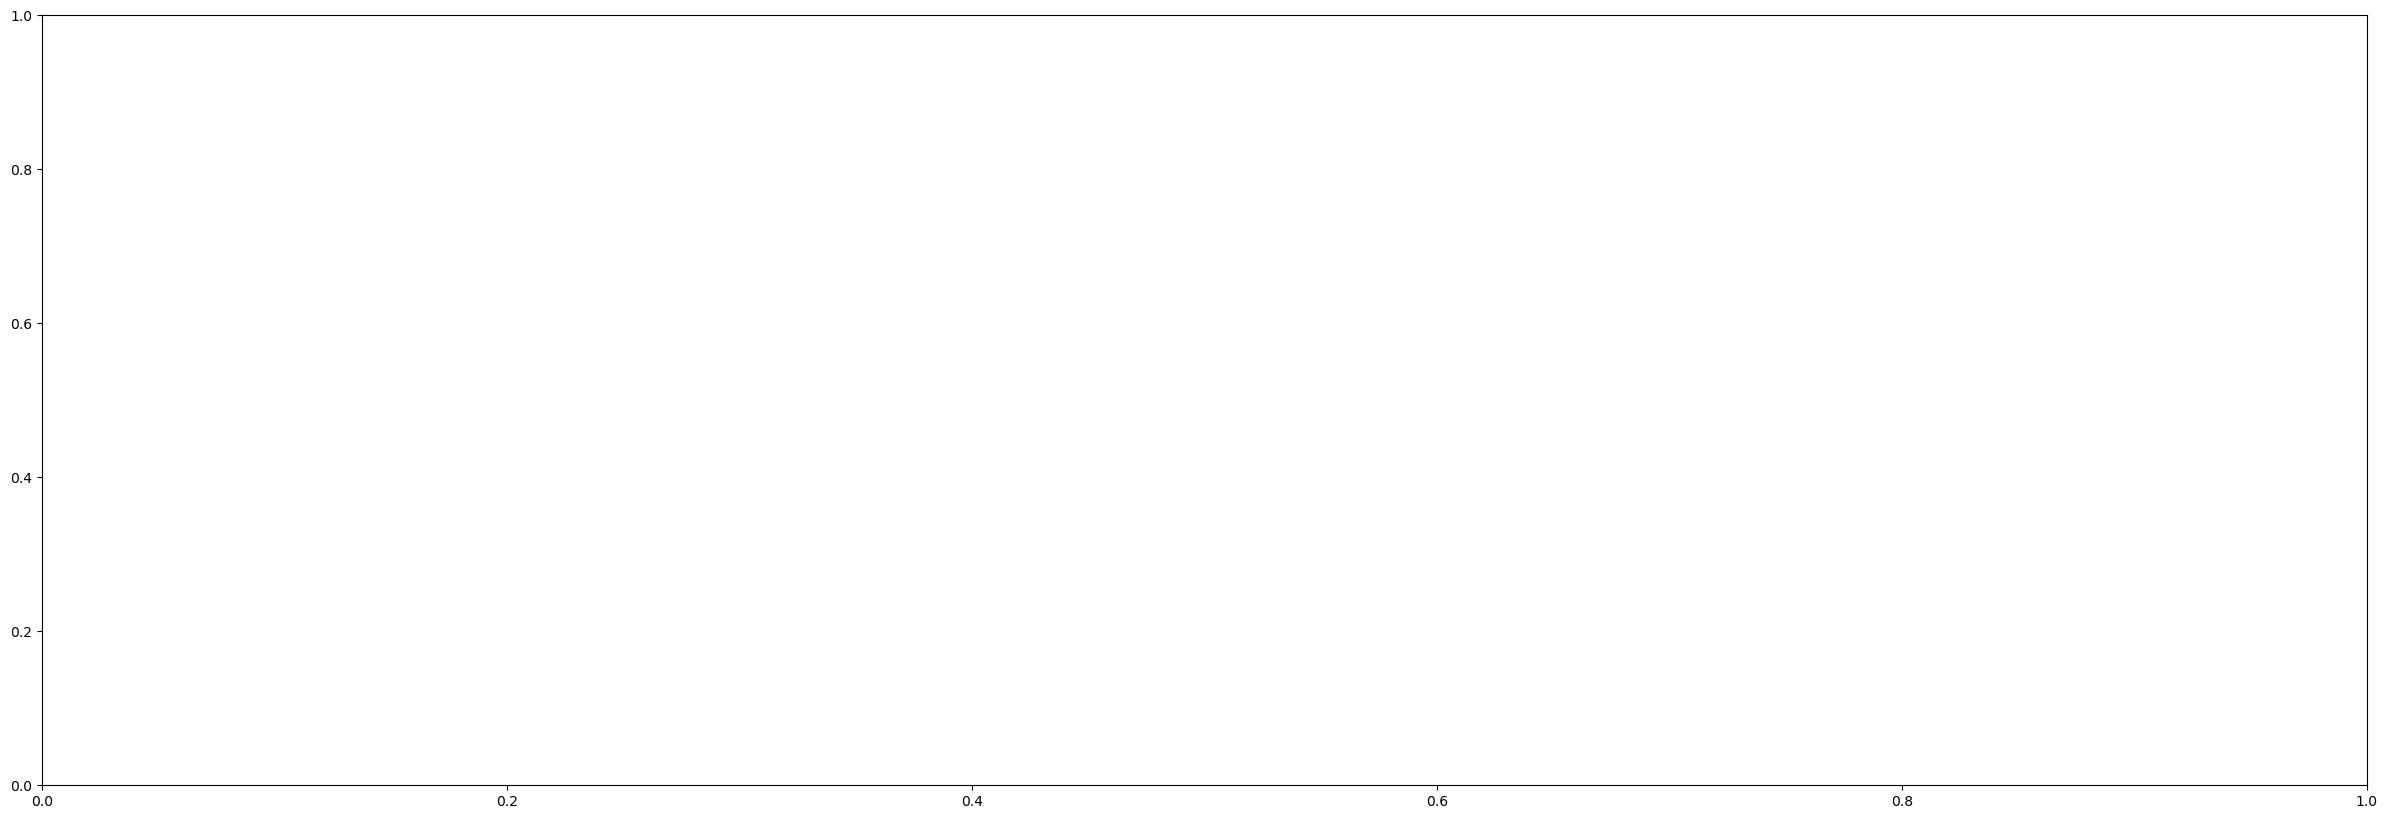

In [31]:
A = np.array(QL_James.q_table)
res = A.max(axis=1)
res2 = np.sort(A, axis=1)[:, -2]
QL = np.zeros((env_states,env_actions))
for i in range(env_states):
    for j in range(env_actions):
        if A[i][j] == res[i]:
            QL[i][j] = 1
        elif A[i][j] == res2[i]:
            QL[i][j] = 0.5
        else:
            QL[i][j] = 0

B = np.array(SA_James.q_table)
res = B.max(axis=1)
res2 = np.sort(B, axis=1)[:, -2]
SA = np.zeros((env_states,env_actions))
for i in range(env_states):
    for j in range(env_actions):
        if B[i][j] == res[i]:
            SA[i][j] = 1
        elif B[i][j] == res2[i]:
            SA[i][j] = 0.5
        else:
            SA[i][j] = 0


import seaborn as sns
actions=("Left","Right","Up","Down")
fig, axes = plt.subplots(1,2, figsize=(12,12))
ax1, ax2 = axes
im1 = ax1.matshow(QL)
im2 = ax2.matshow(SA)
ax1.set_title("Q-learning")
ax2.set_title("SARSA")
ax1.set_yticks(range(env_states))
ax1.set_xticks(range(env_actions))
ax1.set_xticklabels(actions,rotation=45)
ax2.set_yticks(range(env_states))
ax2.set_xticks(range(env_actions))
ax2.set_xticklabels(actions,rotation=45)
plt.tight_layout()
plt.figure(figsize=(30,10))
plt.colorbar(im1)
plt.show()


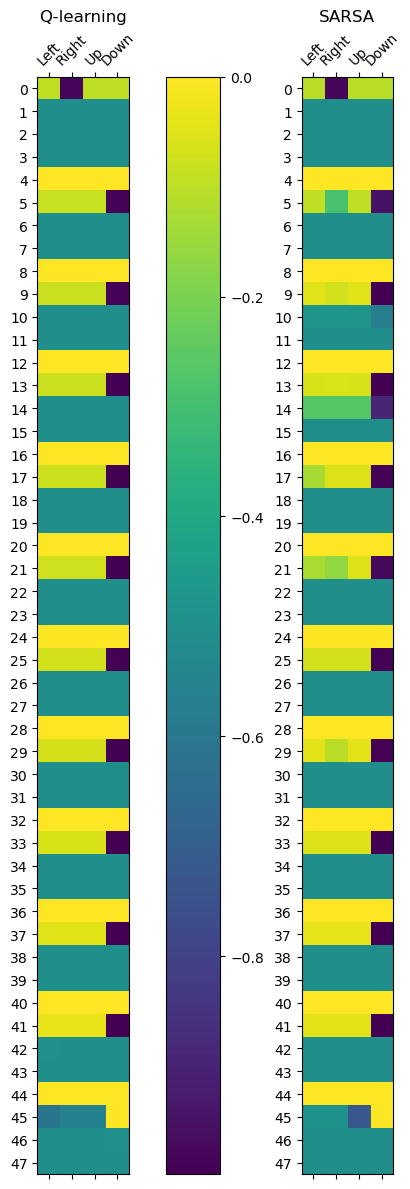

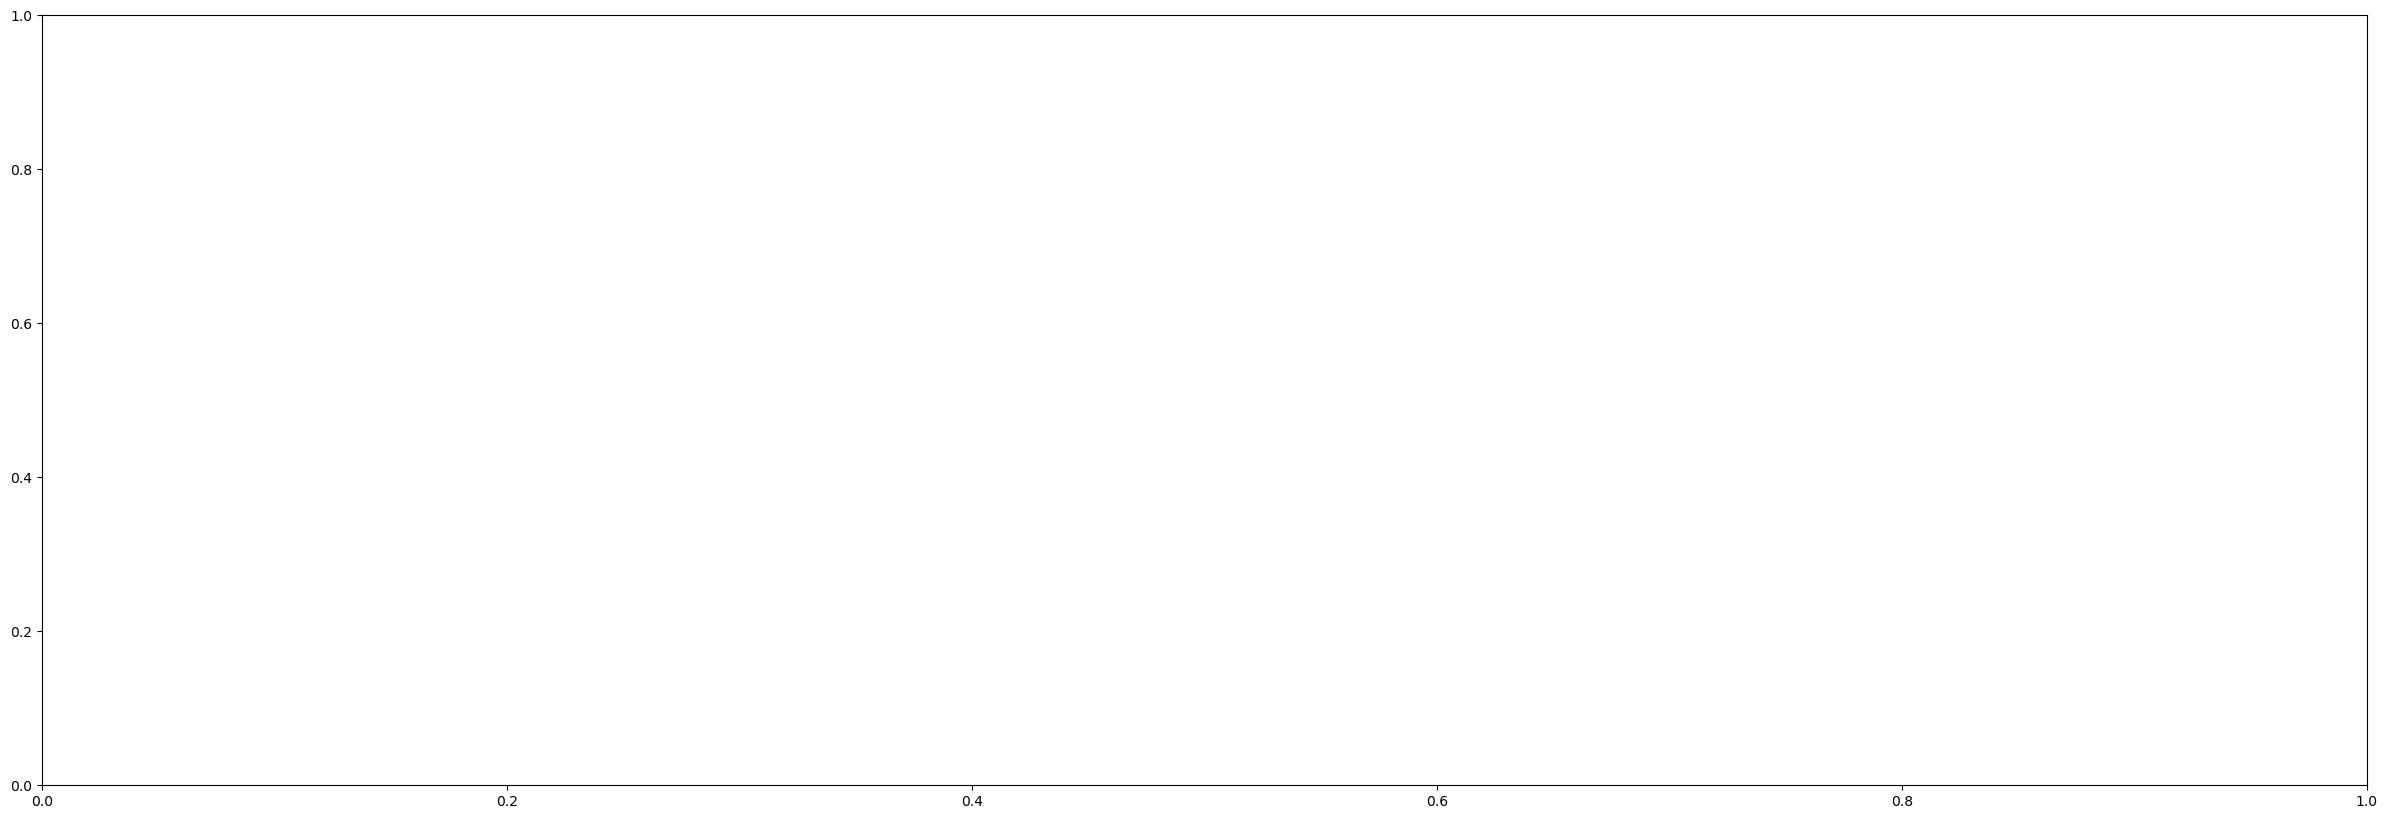

In [23]:
from sklearn.preprocessing import Normalizer
import pandas as pd
transformer = Normalizer().fit(QL_James.q_table)
Q_scaled_qtable = transformer.transform(QL_James.q_table)

transformer = Normalizer().fit(SA_James.q_table)
SA_scaled_qtable = transformer.transform(SA_James.q_table)

import seaborn as sns
actions=("Left","Right","Up","Down")
fig, axes = plt.subplots(1,2, figsize=(12,12))
ax1, ax2 = axes
im1 = ax1.matshow(Q_scaled_qtable)
im2 = ax2.matshow(SA_scaled_qtable)
ax1.set_title("Q-learning")
ax2.set_title("SARSA")
ax1.set_yticks(range(env_states))
ax1.set_xticks(range(env_actions))
ax1.set_xticklabels(actions,rotation=45)
ax2.set_yticks(range(env_states))
ax2.set_xticks(range(env_actions))
ax2.set_xticklabels(actions,rotation=45)
plt.tight_layout()
plt.figure(figsize=(30,10))
plt.colorbar(im1)
plt.show()

## 2. The cartpole environment

Solve the cartpole environment by means of both Q-learning and SARSA. 
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Q-learing and SARSA take discrete states as inputs. The cartpole environments outputs continuous state vectors. 
Therefore you will have to discretize these continuous state vectors. 
For example the cart position can vary in the range of -2.4 -> 2.4. You will have to discretize this range in a number of bins (for example 10 bins).
The numpy function 'digitize' can be used for discretization. More information about this function: https://numpy.org/doc/stable/reference/generated/numpy.digitize.html

- Implement the Q-learning algorithm. Write your own implementation and tune the hyperparameters (learning rate, discount factor, epsilon). Use epsilon decay if necessary. 
- Record the learning history. This means that for each episode you register the total episodic reward. After learning, plot the training history (x-axis = episode number; y-axis: total episodic reward). Especially in the beginning, the episodic rewards can be erratic because the agent is still exploring and has little knowledge of the environment. Therefore it can be a good idea to plot the moving average of the episodic rewards. For example, the average episodic reward achieved over 10 episodes.
- Check if you can make the agent learn faster by using an adaptive learning rate. You start with a high learning rate and you decrease gradually as the agent learns.
- Can you change the reward function in order to make the agent learn faster. For example by changing the reward values or by adding new rewards that make the reward function less sparse.

- Modify you Q-learing implementation to a SARSA implementation.

- Compare Q-learing with SARSA in terms of speed of learning, but especially in terms of the learned policy. 


In [ ]:
# Solving the cartpole environment

env_name = "CartPole-v0"
env = gym.make(env_name)